In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt', download_dir='C:\\Users\\Phong\\AppData\\Roaming\\nltk_data')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Phong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Phong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Phong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = 'https://raw.githubusercontent.com/whosphong/Ai_Startup_Failure--UAMATH509/refs/heads/main/Test1.csv'

In [3]:
df = pd.read_csv(data)

In [4]:
df.shape

(382, 19)

In [5]:
data_org = df.copy()

C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1622134453.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




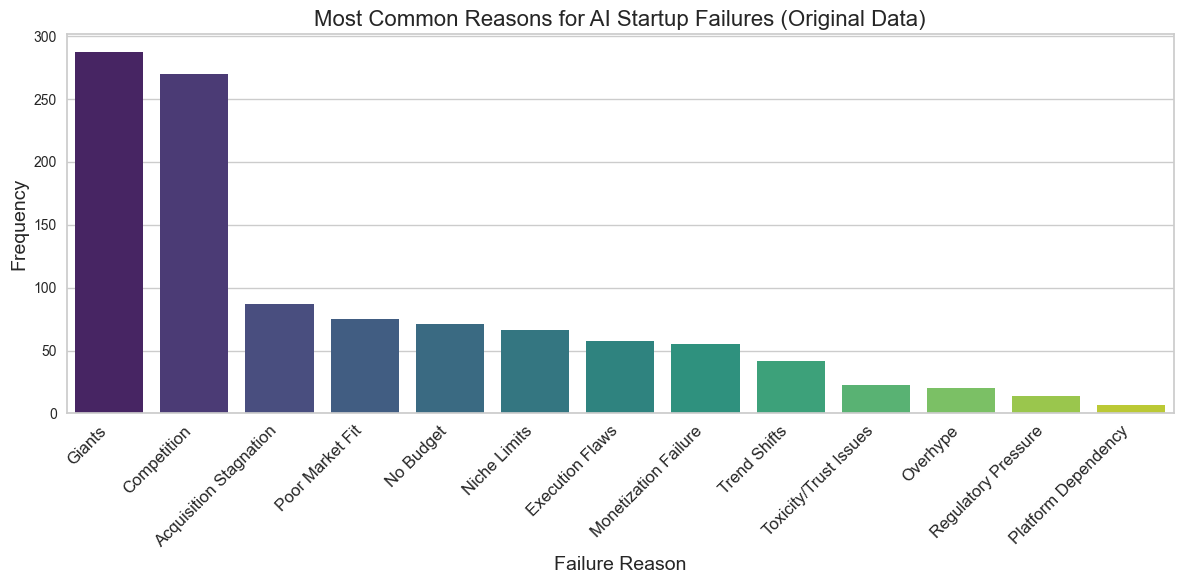

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the original data (assuming you have df available)
data_org = df.copy()

# Updated list of failure-related columns from the dataset
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Sum the number of 1s (indicating failure) for each failure reason across the whole dataset
failure_counts_org = data_org[failure_columns].sum()

# Sort the reasons by their frequency in descending order
failure_counts_org = failure_counts_org.sort_values(ascending=False)

# Create a bar chart to visualize the data
plt.figure(figsize=(12, 6))
sns.barplot(x=failure_counts_org.index, y=failure_counts_org.values, palette='viridis')

# Add labels and title
plt.xlabel('Failure Reason', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Most Common Reasons for AI Startup Failures (Original Data)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
columns_to_log_transform = ['Years of Operation', 'How Much They Raised (Millions)']
log_transformed_columns = np.log1p(data_org[columns_to_log_transform])  # Apply log(1 + x) transformation
log_transformed_columns_df = pd.DataFrame(log_transformed_columns, columns=columns_to_log_transform)
data_dropped = data_org.drop(columns=columns_to_log_transform)
data = pd.concat([data_dropped.reset_index(drop=True), log_transformed_columns_df.reset_index(drop=True)], axis=1)


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())  # Remove non-alphabetical characters
    words = word_tokenize(text)  # Tokenize the text
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(words)

# Apply preprocessing to the relevant columns in your dataset (excluding 'Takeaway')
data['What They Did'] = data['What They Did'].apply(preprocess_text)
data['Why They Failed'] = data['Why They Failed'].apply(preprocess_text)

In [8]:
# Fit a single vectorizer for both text columns
vectorizer = TfidfVectorizer(max_features=500)  # Adjust max_features if needed

# Transform both 'What They Did' and 'Why They Failed' with the same vectorizer
X_what_they_did = vectorizer.fit_transform(data['What They Did'])
X_why_they_failed = vectorizer.transform(data['Why They Failed'])  # Use the same vectorizer here

# Convert the sparse matrices to DataFrames
text_features_what = pd.DataFrame(X_what_they_did.toarray(), columns=vectorizer.get_feature_names_out())
text_features_failed = pd.DataFrame(X_why_they_failed.toarray(), columns=vectorizer.get_feature_names_out())

# Select numerical features from the dataset
numerical_features = data[['Years of Operation', 'How Much They Raised (Millions)', 
                           'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 
                           'Acquisition Stagnation', 'Platform Dependency', 'Monetization Failure',
                           'Niche Limits', 'Execution Flaws', 'Trend Shifts', 'Toxicity/Trust Issues',
                           'Regulatory Pressure', 'Overhype']]

# Reset the index of all feature DataFrames
text_features_what = text_features_what.reset_index(drop=True)
text_features_failed = text_features_failed.reset_index(drop=True)
numerical_features = numerical_features.reset_index(drop=True)

# Concatenate the text and numerical features into a single DataFrame
features_what = pd.concat([text_features_what, numerical_features], axis=1)
features_failed = pd.concat([text_features_failed, numerical_features], axis=1)

# 1

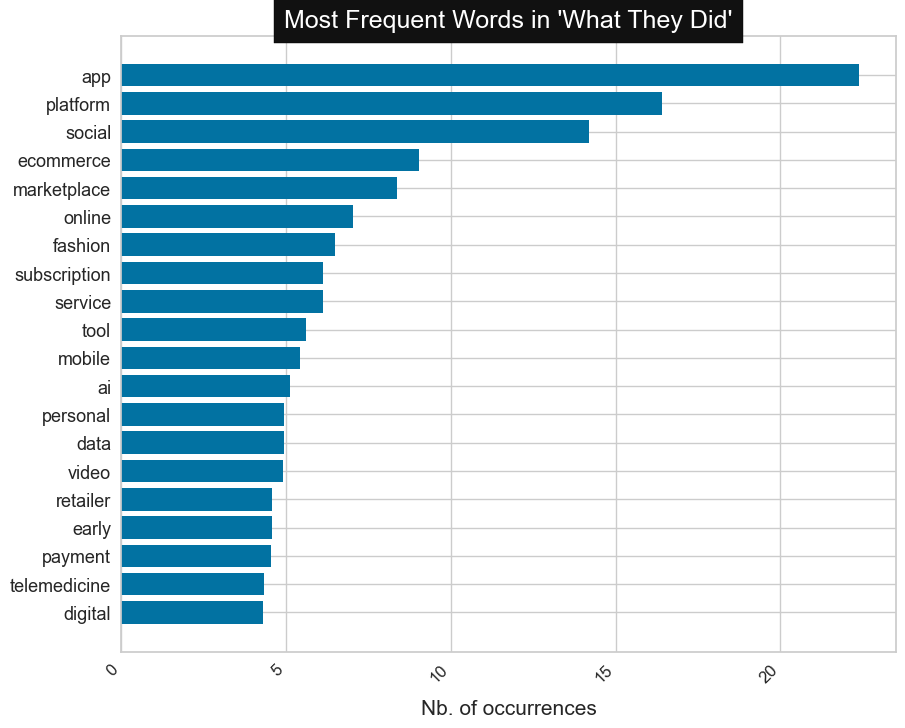

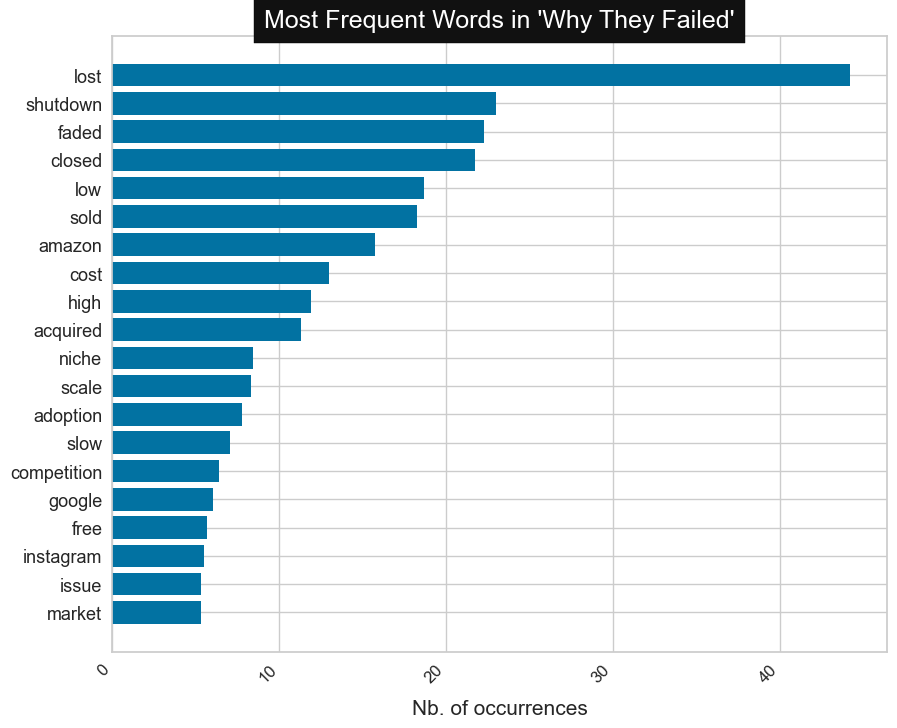

In [9]:
# Function to plot most frequent words in a given column
def plot_most_frequent_words(text_column, title):
    # Use TfidfVectorizer to count the frequency of each word
    vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 words
    X = vectorizer.fit_transform(data[text_column])
    word_freq = X.toarray().sum(axis=0)  # Sum the occurrences across all samples
    
    # Get the words and their corresponding frequencies
    words = vectorizer.get_feature_names_out()
    word_counts = dict(zip(words, word_freq))
    
    # Sort the words by frequency in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Prepare the data for plotting
    N = 20  # Top N most frequent words to display
    sorted_word_counts_top = sorted_word_counts[:N]
    x_axis = [item[0] for item in sorted_word_counts_top]
    y_axis = [item[1] for item in sorted_word_counts_top]
    
    # Plotting the top N most frequent words
    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=13)
    ax.barh(x_axis, y_axis, align='center')
    ax.invert_yaxis()  # Invert y-axis to show the highest frequency word at the top
    plt.xlabel("Nb. of occurrences", fontsize=15, labelpad=10)
    plt.title(title, bbox={'facecolor': 'k', 'pad': 5}, color='w', fontsize=18)
    plt.show()

# Plot most frequent words for "What They Did"
plot_most_frequent_words('What They Did', "Most Frequent Words in 'What They Did'")

# Plot most frequent words for "Why They Failed"
plot_most_frequent_words('Why They Failed', "Most Frequent Words in 'Why They Failed'")

Cluster distribution for 'What They Did':
Cluster_What
1    225
0    157
Name: count, dtype: int64


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1278298919.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




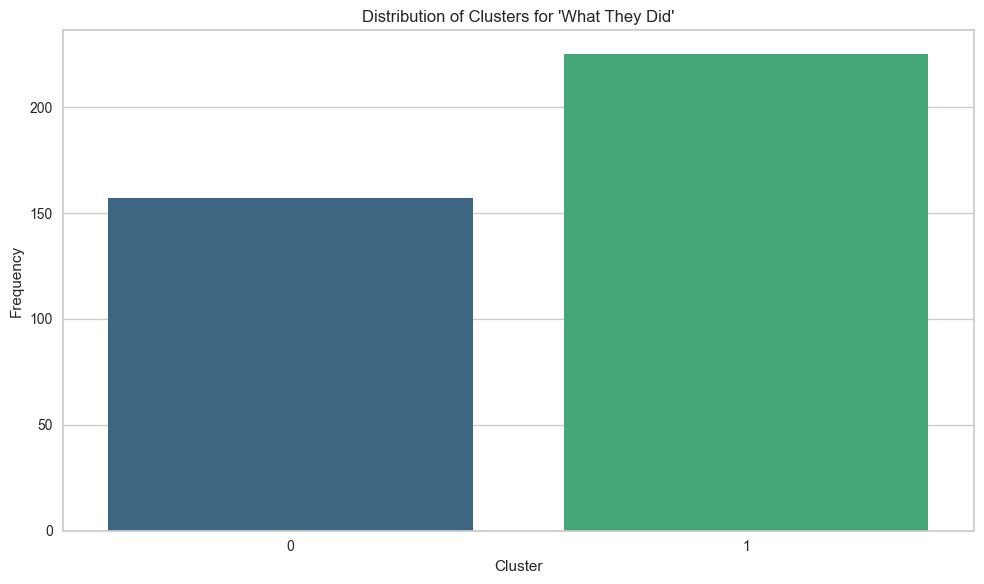

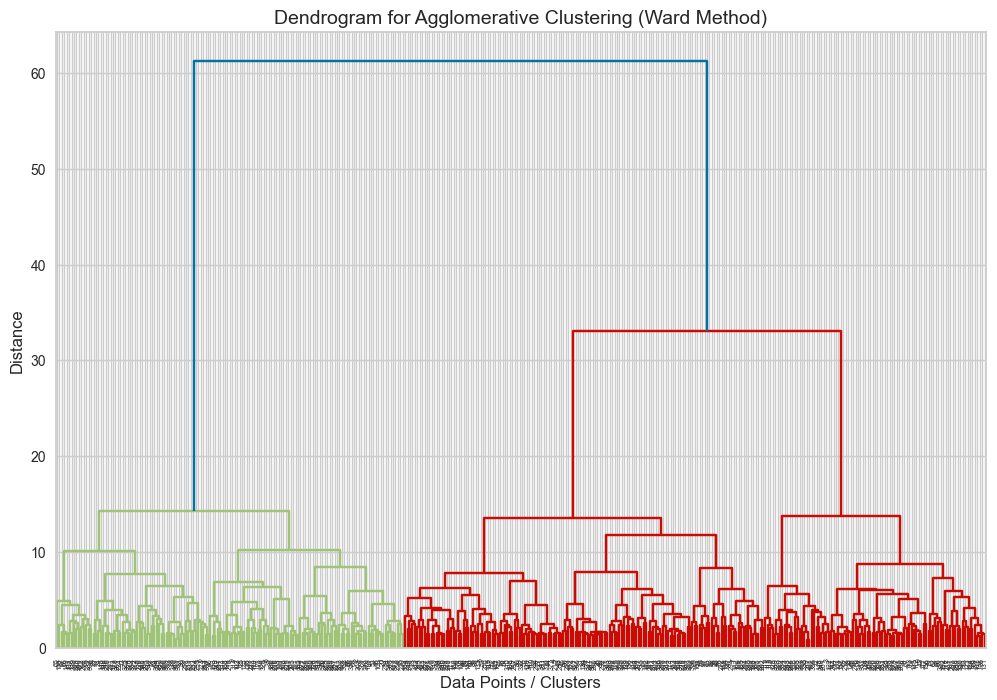

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure your numerical and text features related to 'What They Did' are concatenated properly for clustering
features_combined = pd.concat([features_what, numerical_features], axis=1)

# Compute the linkage matrix using different linkage methods
linkage_methods = ['ward', 'average', 'single', 'complete', 'weighted', 'centroid', 'median']
cophenetic_values = []

# Perform the hierarchical clustering and calculate the cophenetic correlation for each linkage method
for method in linkage_methods:
    Z = linkage(features_combined, method)
    c, _ = cophenet(Z, pdist(features_combined))
    cophenetic_values.append(c)

# Create a bar plot to visualize cophenetic correlation coefficients
fig = go.Figure([go.Bar(x=linkage_methods, y=cophenetic_values)])

# Add title and axis labels
fig.update_layout(
    title="Cophenetic Correlation Coefficients for Different Linkage Methods",
    xaxis_title="Linkage Methods",
    yaxis_title="Cophenetic Correlation Coefficient",
    showlegend=False
)

# Optionally, add annotations on top of the bars
for i, val in enumerate(cophenetic_values):
    fig.add_annotation(
        x=linkage_methods[i],
        y=val,
        text=f"{val:.5f}",
        showarrow=False,
        font=dict(size=12, color="black"),
        align="center",
        yshift=10
    )

# Show the plot
fig.show()

# Now, perform Agglomerative Clustering using the 'ward' linkage method for 'What They Did'
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='average')  # Adjust the number of clusters as needed
data['Cluster_What'] = agg_clustering.fit_predict(features_what)

# Check the distribution of clusters for 'What They Did'
print("Cluster distribution for 'What They Did':")
print(data['Cluster_What'].value_counts())

# Visualize the distribution of clusters using a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_What', data=data, palette='viridis')
plt.title("Distribution of Clusters for 'What They Did'")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optionally, visualize the dendrogram (optional but informative) for the selected linkage method
plt.figure(figsize=(12, 8))
Z = linkage(features_combined, method='ward')  # Change the linkage method if desired
dendrogram(Z)
plt.title("Dendrogram for Agglomerative Clustering (Ward Method)", fontsize=14)
plt.xlabel('Data Points / Clusters', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()


In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

# Assuming features_combined is the dataset you want to cluster (combine your text and numerical features)
# Loop through a range of n_clusters (from 2 to 9) to evaluate the clustering performance
for n_clusters in range(2, 10):
    # Initialize the AgglomerativeClustering model with the current number of clusters
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None)
    
    # Fit the model and predict the cluster labels
    preds = clusterer.fit_predict(features_combined)
    
    # Calculate the silhouette score
    silhouette = silhouette_score(features_combined, preds)
    
    # Calculate the Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(features_combined, preds)
    
    # Calculate the Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(features_combined, preds)
    
    # Print the metrics for the current n_clusters
    print(f"For n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette:.3f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.3f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.3f}")
    print("-" * 50)


For n_clusters = 2:
  Silhouette Score: 0.328
  Calinski-Harabasz Index: 271.976
  Davies-Bouldin Index: 1.080
--------------------------------------------------
For n_clusters = 3:
  Silhouette Score: 0.226
  Calinski-Harabasz Index: 220.998
  Davies-Bouldin Index: 1.424
--------------------------------------------------
For n_clusters = 4:
  Silhouette Score: 0.138
  Calinski-Harabasz Index: 161.108
  Davies-Bouldin Index: 2.005
--------------------------------------------------
For n_clusters = 5:
  Silhouette Score: 0.099
  Calinski-Harabasz Index: 131.281
  Davies-Bouldin Index: 2.110
--------------------------------------------------
For n_clusters = 6:
  Silhouette Score: 0.079
  Calinski-Harabasz Index: 114.047
  Davies-Bouldin Index: 2.391
--------------------------------------------------
For n_clusters = 7:
  Silhouette Score: 0.080
  Calinski-Harabasz Index: 101.103
  Davies-Bouldin Index: 2.261
--------------------------------------------------
For n_clusters = 8:
  Silhou

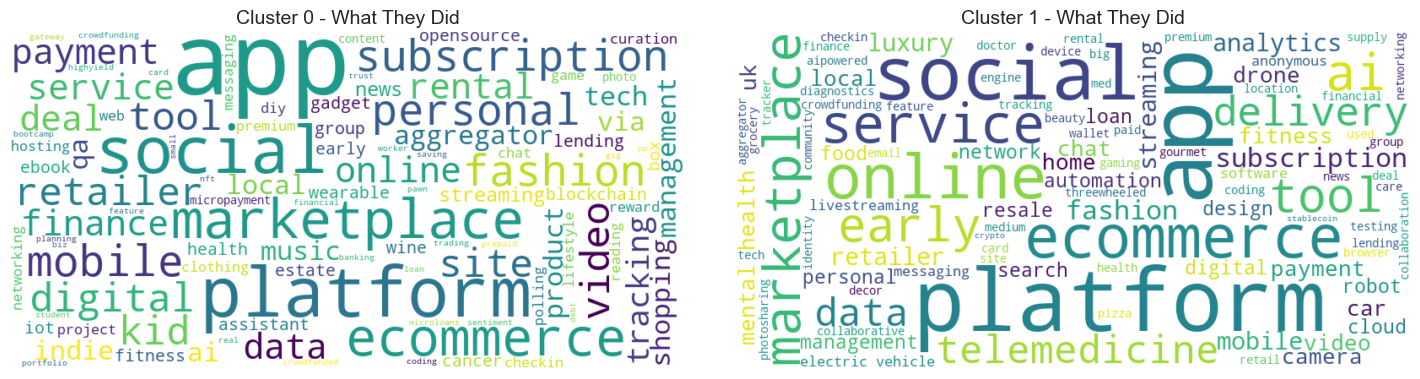

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Number of clusters
num_clusters = data['Cluster_What'].nunique()

# Create a figure with subplots (one for each cluster)
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 8))

# Iterate through each cluster and generate a word cloud for the 'What They Did' column
for cluster_num in range(num_clusters):
    # Get the text for the current cluster
    cluster_text = " ".join(data[data['Cluster_What'] == cluster_num]['What They Did'])  # Concatenate all text for the cluster
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(cluster_text)
    
    # Plot the word cloud
    ax = axes[cluster_num]  # Select the axis for the current cluster
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Cluster {cluster_num} - What They Did', fontsize=14)

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1079918976.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1079918976.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




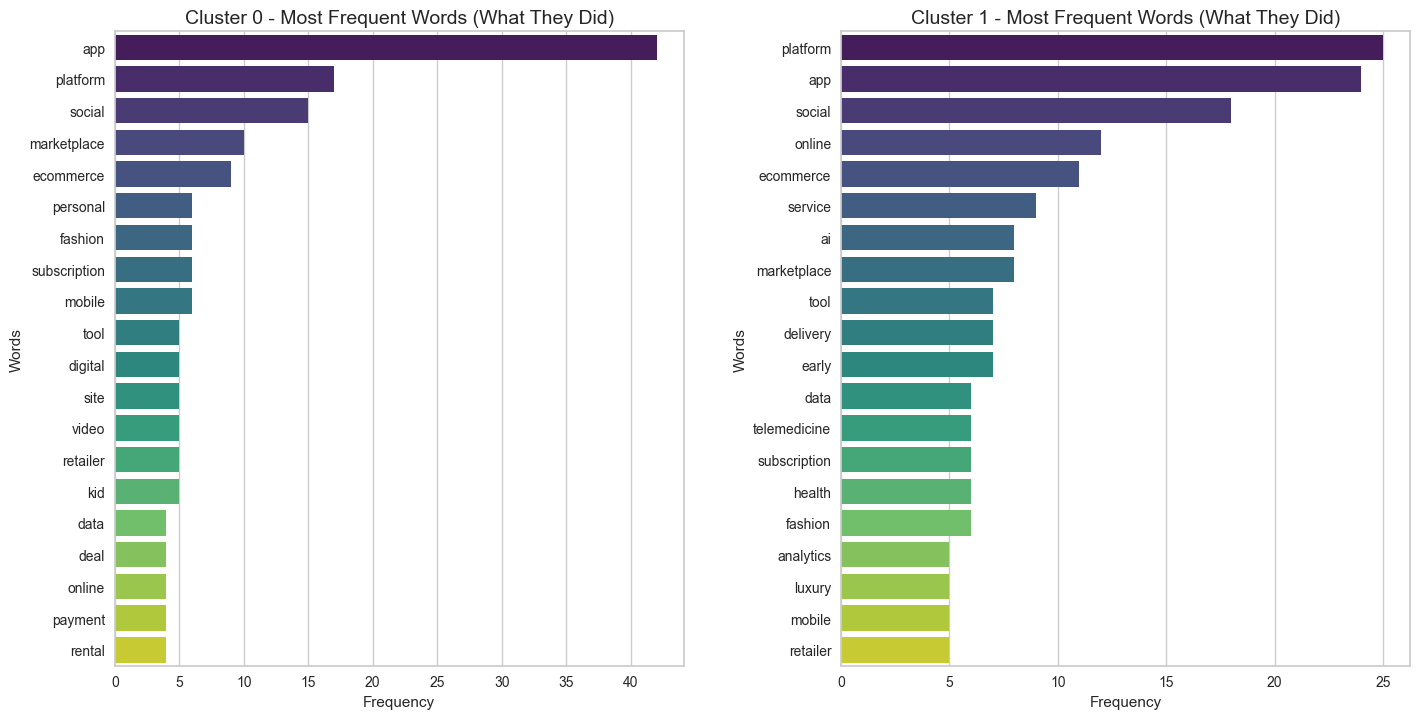

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Number of clusters for 'Why They Failed'
num_clusters_failed = data['Cluster_What'].nunique()

# Set up subplots for the bar charts
fig, axes = plt.subplots(1, num_clusters_failed, figsize=(15, 8))

# Iterate through each cluster and generate a bar chart for the most frequent words in 'Why They Failed'
for cluster_num in range(num_clusters_failed):
    # Get the text for the current cluster
    cluster_text = " ".join(data[data['Cluster_What'] == cluster_num]['What They Did'])  # Concatenate all text for the cluster
    
    # Use CountVectorizer to tokenize the text and count word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Limit to top 20 most frequent words
    word_counts = vectorizer.fit_transform([cluster_text]).toarray().flatten()
    
    # Create a DataFrame for easy sorting
    word_freq = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': word_counts
    })
    
    # Sort the words by frequency in descending order
    word_freq_sorted = word_freq.sort_values(by='count', ascending=False)
    
    # Plot a bar chart of the most frequent words for the current cluster
    ax = axes[cluster_num]
    sns.barplot(x='count', y='word', data=word_freq_sorted, ax=ax, palette='viridis')
    
    # Set the title for the current cluster
    ax.set_title(f"Cluster {cluster_num} - Most Frequent Words (What They Did)", fontsize=14)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1171772427.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1171772427.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1171772427.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1171772427.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



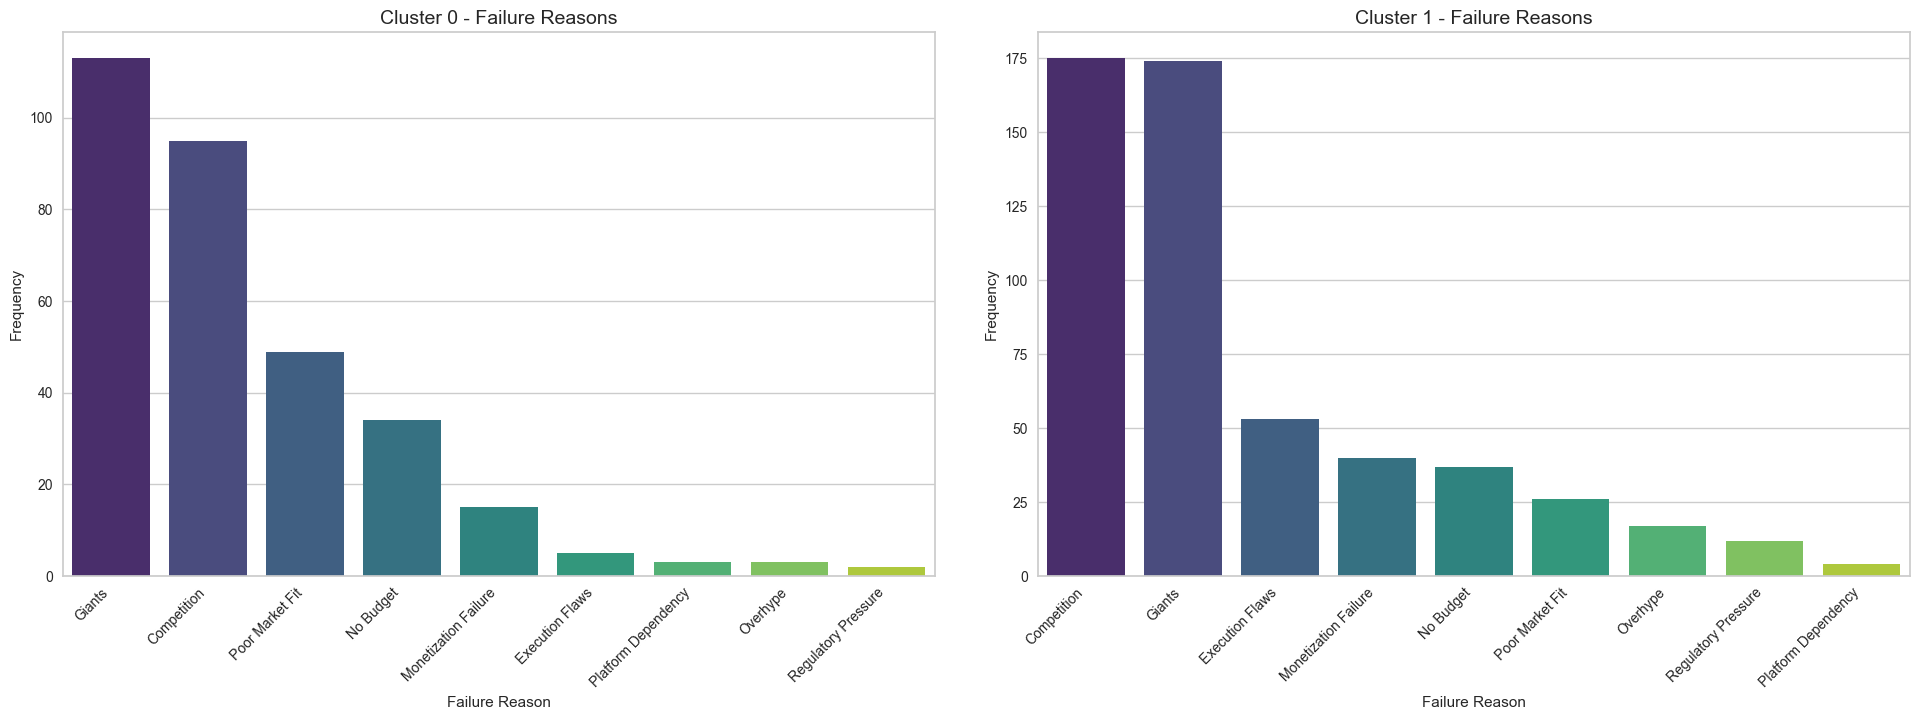

In [ ]:
# List of failure-related columns from the dataset
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Create a figure with subplots (one for each cluster)
num_clusters_failed = data['Cluster_What'].nunique()
fig, axes = plt.subplots(1, num_clusters_failed, figsize=(20, 8))

# Iterate through each cluster and generate a bar chart for the failure-related columns
for cluster_num in range(num_clusters_failed):
    # Subset the data for the current cluster
    cluster_data = data[data['Cluster_What'] == cluster_num]
    
    # Sum the failure-related columns for the current cluster
    failure_counts_cluster = cluster_data[failure_columns].sum()

    # Sort the failure reasons by their frequency in descending order
    failure_counts_cluster = failure_counts_cluster.sort_values(ascending=False)

    # Plot a bar chart for the current cluster
    ax = axes[cluster_num]
    sns.barplot(x=failure_counts_cluster.index, y=failure_counts_cluster.values, ax=ax, palette='viridis')

    # Set the title and labels for the current cluster
    ax.set_title(f"Cluster {cluster_num} - Failure Reasons", fontsize=14)
    ax.set_xlabel("Failure Reason")
    ax.set_ylabel("Frequency")
    ax.set_xticklabels(failure_counts_cluster.index, rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()

Cluster distribution for 'Why They Failed':
Cluster_Failed
1    211
0    171
Name: count, dtype: int64


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2601031148.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




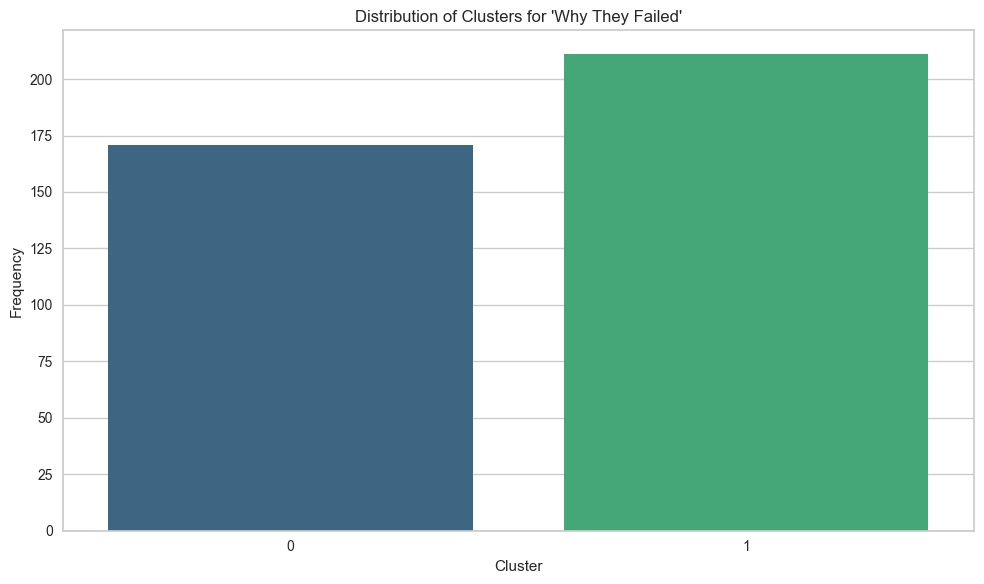

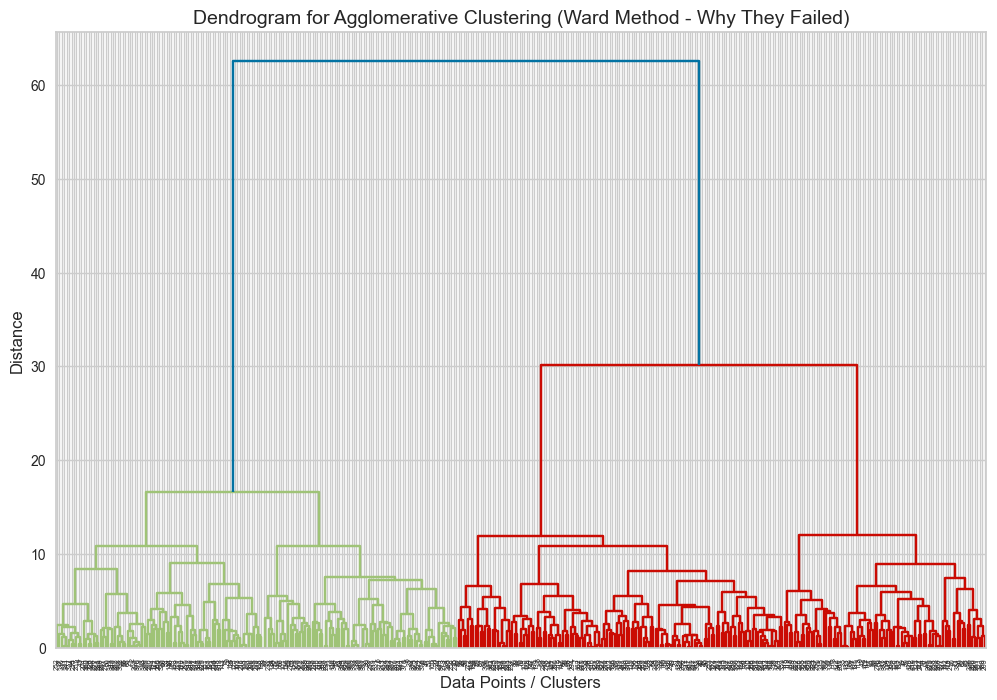

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure your numerical and text features related to 'Why They Failed' are concatenated properly for clustering
features_combined_failed = pd.concat([features_failed, numerical_features], axis=1)

# Compute the linkage matrix using different linkage methods
linkage_methods = ['ward', 'average', 'single', 'complete', 'weighted', 'centroid', 'median']
cophenetic_values_failed = []

# Perform the hierarchical clustering and calculate the cophenetic correlation for each linkage method
for method in linkage_methods:
    Z = linkage(features_combined_failed, method)
    c, _ = cophenet(Z, pdist(features_combined_failed))
    cophenetic_values_failed.append(c)

# Create a bar plot to visualize cophenetic correlation coefficients
fig = go.Figure([go.Bar(x=linkage_methods, y=cophenetic_values_failed)])

# Add title and axis labels
fig.update_layout(
    title="Cophenetic Correlation Coefficients for Different Linkage Methods (Why They Failed)",
    xaxis_title="Linkage Methods",
    yaxis_title="Cophenetic Correlation Coefficient",
    showlegend=False
)

# Optionally, add annotations on top of the bars
for i, val in enumerate(cophenetic_values_failed):
    fig.add_annotation(
        x=linkage_methods[i],
        y=val,
        text=f"{val:.5f}",
        showarrow=False,
        font=dict(size=12, color="black"),
        align="center",
        yshift=10
    )

# Show the plot
fig.show()

# Now, perform Agglomerative Clustering using the 'ward' linkage method for 'Why They Failed'
agg_clustering_failed = AgglomerativeClustering(n_clusters=2, linkage='average')  # Adjust the number of clusters as needed
data['Cluster_Failed'] = agg_clustering_failed.fit_predict(features_failed)

# Check the distribution of clusters for 'Why They Failed'
print("Cluster distribution for 'Why They Failed':")
print(data['Cluster_Failed'].value_counts())

# Visualize the distribution of clusters using a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_Failed', data=data, palette='viridis')
plt.title("Distribution of Clusters for 'Why They Failed'")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optionally, visualize the dendrogram (optional but informative) for the selected linkage method
plt.figure(figsize=(12, 8))
Z_failed = linkage(features_combined_failed, method='ward')  # Change the linkage method if desired
dendrogram(Z_failed)
plt.title("Dendrogram for Agglomerative Clustering (Ward Method - Why They Failed)", fontsize=14)
plt.xlabel('Data Points / Clusters', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()


In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

# Assuming features_combined_failed is the dataset you want to cluster (combine your text and numerical features)
# Loop through a range of n_clusters (from 2 to 9) to evaluate the clustering performance
for n_clusters in range(2, 10):
    # Initialize the AgglomerativeClustering model with the current number of clusters
    clusterer_failed = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None)
    
    # Fit the model and predict the cluster labels
    preds_failed = clusterer_failed.fit_predict(features_combined_failed)
    
    # Calculate the silhouette score
    silhouette_failed = silhouette_score(features_combined_failed, preds_failed)
    
    # Calculate the Calinski-Harabasz Index
    calinski_harabasz_failed = calinski_harabasz_score(features_combined_failed, preds_failed)
    
    # Calculate the Davies-Bouldin Index
    davies_bouldin_failed = davies_bouldin_score(features_combined_failed, preds_failed)
    
    # Print the metrics for the current n_clusters
    print(f"For n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette_failed:.3f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_failed:.3f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_failed:.3f}")
    print("-" * 50)


For n_clusters = 2:
  Silhouette Score: 0.355
  Calinski-Harabasz Index: 318.996
  Davies-Bouldin Index: 1.030
--------------------------------------------------
For n_clusters = 3:
  Silhouette Score: 0.245
  Calinski-Harabasz Index: 243.125
  Davies-Bouldin Index: 1.367
--------------------------------------------------
For n_clusters = 4:
  Silhouette Score: 0.155
  Calinski-Harabasz Index: 184.419
  Davies-Bouldin Index: 1.845
--------------------------------------------------
For n_clusters = 5:
  Silhouette Score: 0.117
  Calinski-Harabasz Index: 148.055
  Davies-Bouldin Index: 1.985
--------------------------------------------------
For n_clusters = 6:
  Silhouette Score: 0.120
  Calinski-Harabasz Index: 126.672
  Davies-Bouldin Index: 2.048
--------------------------------------------------
For n_clusters = 7:
  Silhouette Score: 0.093
  Calinski-Harabasz Index: 111.745
  Davies-Bouldin Index: 2.096
--------------------------------------------------
For n_clusters = 8:
  Silhou

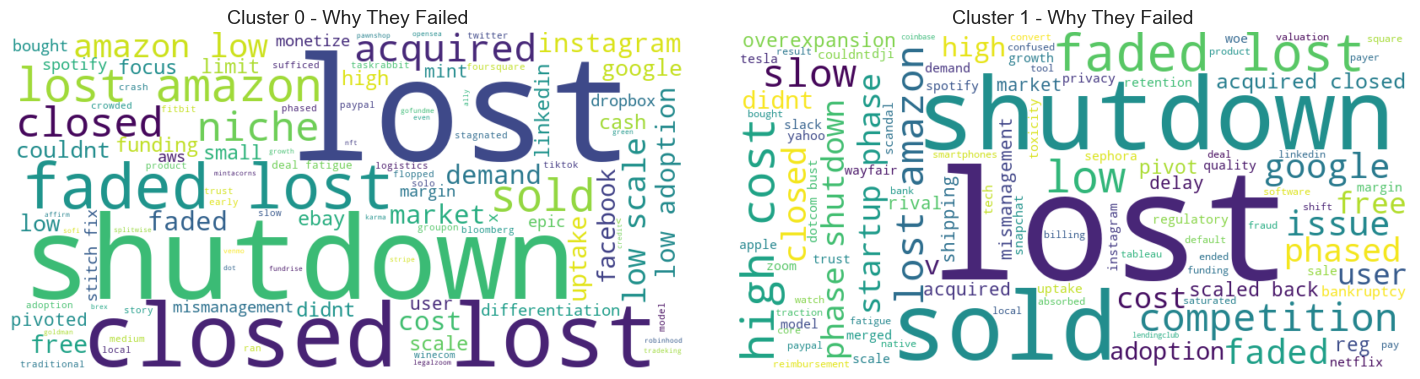

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Number of clusters
num_clusters_failed = data['Cluster_Failed'].nunique()

# Create a figure with subplots (one for each cluster)
fig, axes = plt.subplots(1, num_clusters_failed, figsize=(15, 8))

# Iterate through each cluster and generate a word cloud for the 'Why They Failed' column
for cluster_num in range(num_clusters_failed):
    # Get the text for the current cluster
    cluster_text = " ".join(data[data['Cluster_Failed'] == cluster_num]['Why They Failed'])  # Concatenate all text for the cluster
    
    # Generate the word cloud
    wordcloud_failed = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(cluster_text)
    
    # Plot the word cloud
    ax = axes[cluster_num]  # Select the axis for the current cluster
    ax.imshow(wordcloud_failed, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Cluster {cluster_num} - Why They Failed', fontsize=14)

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2620591527.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2620591527.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




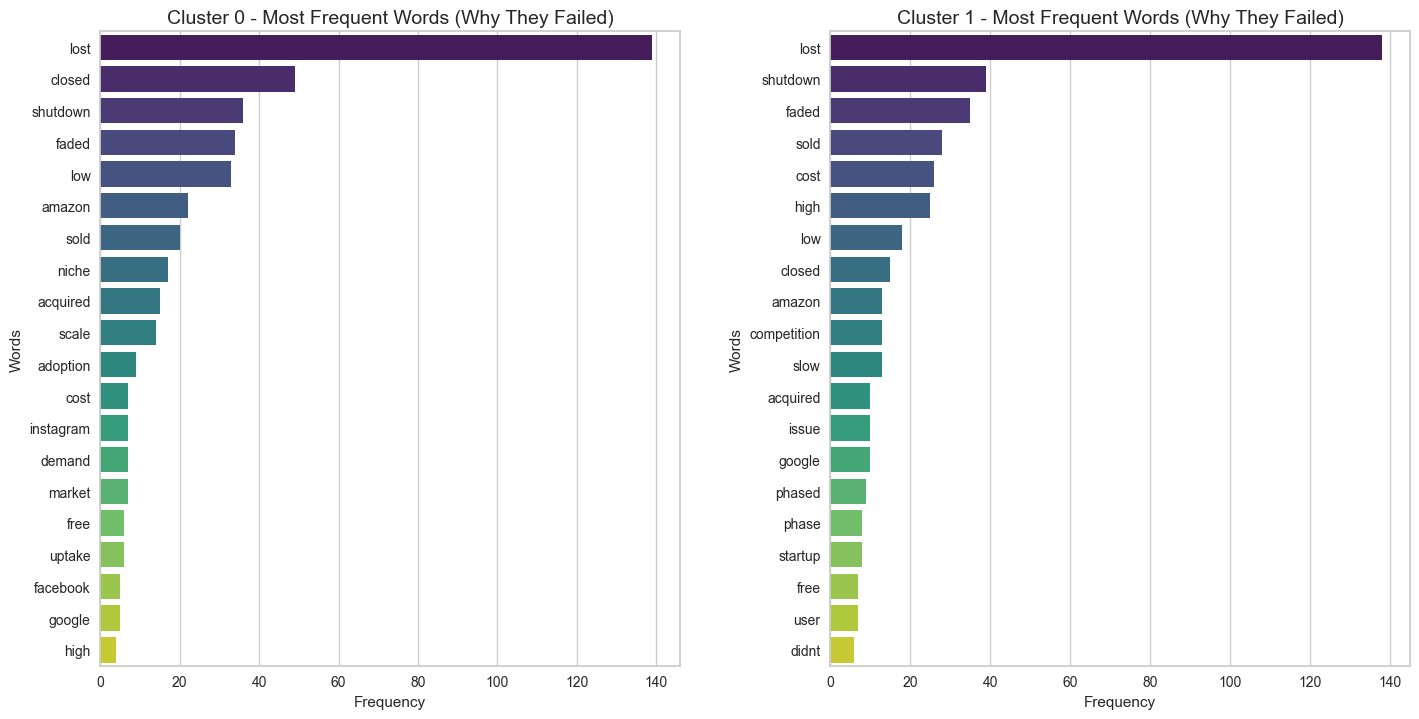

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Number of clusters for 'Why They Failed'
num_clusters_failed = data['Cluster_Failed'].nunique()

# Set up subplots for the bar charts
fig, axes = plt.subplots(1, num_clusters_failed, figsize=(15, 8))

# Iterate through each cluster and generate a bar chart for the most frequent words in 'Why They Failed'
for cluster_num in range(num_clusters_failed):
    # Get the text for the current cluster
    cluster_text = " ".join(data[data['Cluster_Failed'] == cluster_num]['Why They Failed'])  # Concatenate all text for the cluster
    
    # Use CountVectorizer to tokenize the text and count word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Limit to top 20 most frequent words
    word_counts = vectorizer.fit_transform([cluster_text]).toarray().flatten()
    
    # Create a DataFrame for easy sorting
    word_freq = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': word_counts
    })
    
    # Sort the words by frequency in descending order
    word_freq_sorted = word_freq.sort_values(by='count', ascending=False)
    
    # Plot a bar chart of the most frequent words for the current cluster
    ax = axes[cluster_num]
    sns.barplot(x='count', y='word', data=word_freq_sorted, ax=ax, palette='viridis')
    
    # Set the title for the current cluster
    ax.set_title(f"Cluster {cluster_num} - Most Frequent Words (Why They Failed)", fontsize=14)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2860038445.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2860038445.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2860038445.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\2860038445.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



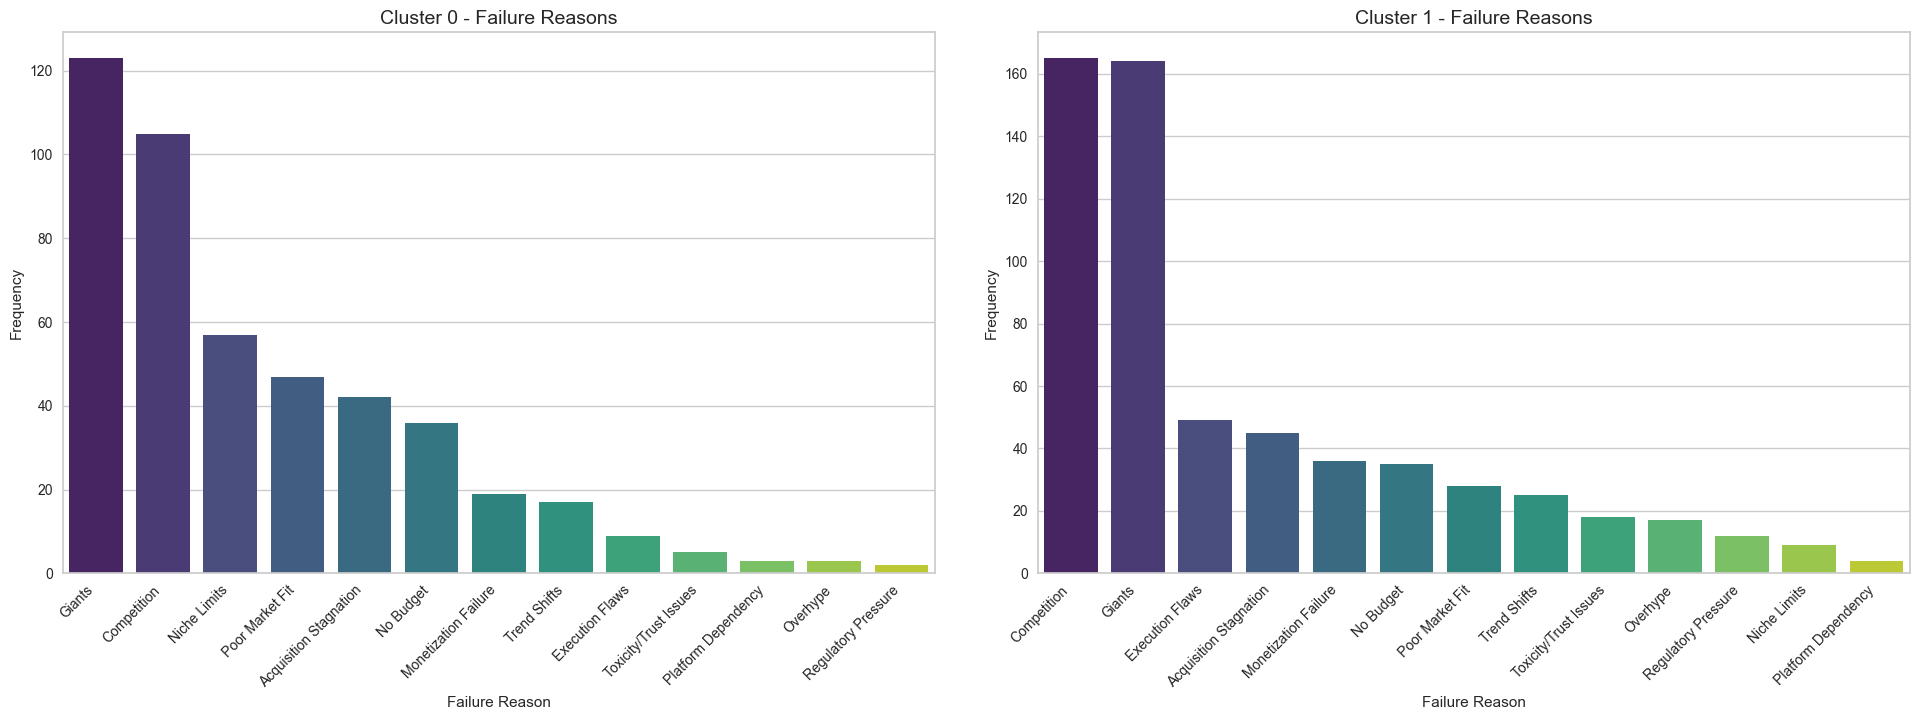

In [23]:
# List of failure-related columns from the dataset
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Create a figure with subplots (one for each cluster)
num_clusters_failed = data['Cluster_Failed'].nunique()
fig, axes = plt.subplots(1, num_clusters_failed, figsize=(20, 8))

# Iterate through each cluster and generate a bar chart for the failure-related columns
for cluster_num in range(num_clusters_failed):
    # Subset the data for the current cluster
    cluster_data = data[data['Cluster_Failed'] == cluster_num]
    
    # Sum the failure-related columns for the current cluster
    failure_counts_cluster = cluster_data[failure_columns].sum()

    # Sort the failure reasons by their frequency in descending order
    failure_counts_cluster = failure_counts_cluster.sort_values(ascending=False)

    # Plot a bar chart for the current cluster
    ax = axes[cluster_num]
    sns.barplot(x=failure_counts_cluster.index, y=failure_counts_cluster.values, ax=ax, palette='viridis')

    # Set the title and labels for the current cluster
    ax.set_title(f"Cluster {cluster_num} - Failure Reasons", fontsize=14)
    ax.set_xlabel("Failure Reason")
    ax.set_ylabel("Frequency")
    ax.set_xticklabels(failure_counts_cluster.index, rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.tight_layout(pad=3)
plt.show()

C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\3583552311.py:34: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



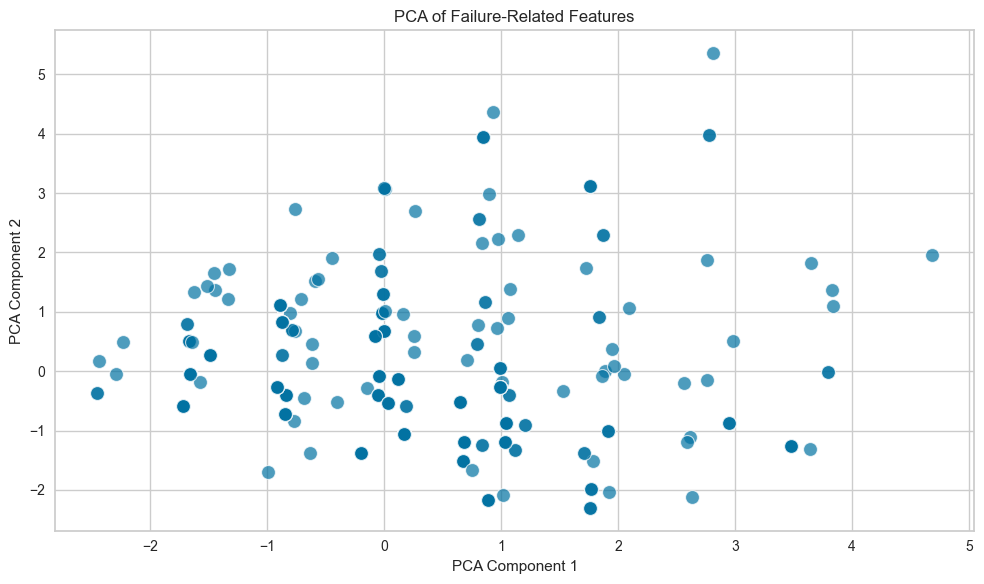

Cluster distribution for Agglomerative Clustering:
Agglomerative_Cluster
1    232
0    150
Name: count, dtype: int64


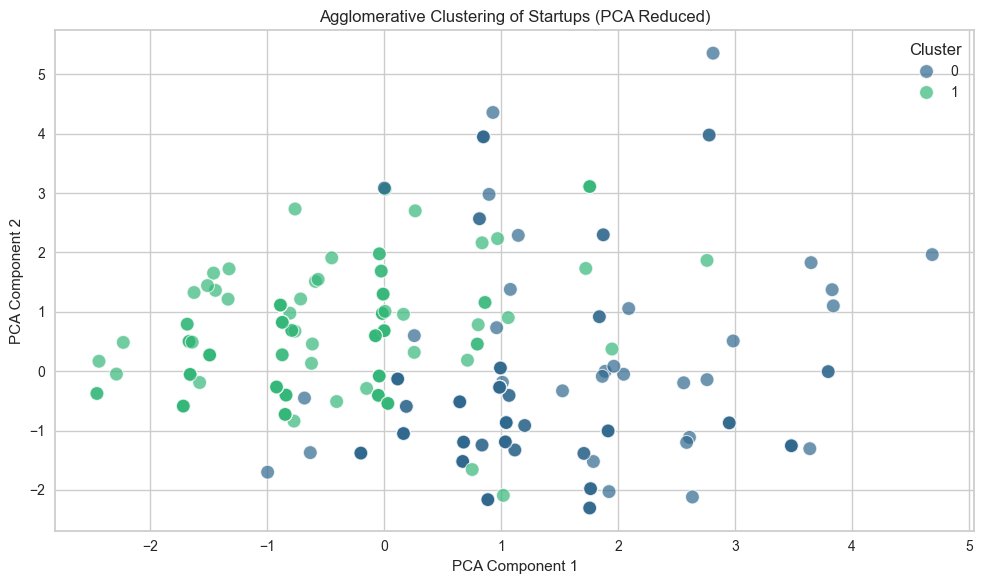

Silhouette Score for Agglomerative Clustering: 0.140


In [54]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Assuming your dataset is in 'data' and contains the failure-related columns
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Step 1: Extract failure-related columns
failure_data = data_org[failure_columns]

# Step 2: Standardize the data (PCA and clustering are sensitive to scale)
scaler = StandardScaler()
failure_data_scaled = scaler.fit_transform(failure_data)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_components = pca.fit_transform(failure_data_scaled)

# Add PCA components to the original data for visualization
data_org['PCA_1'] = pca_components[:, 0]
data_org['PCA_2'] = pca_components[:, 1]

# Visualize the PCA results to get an idea of the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='PCA_1', y='PCA_2', palette='viridis', s=100, alpha=0.7)
plt.title("PCA of Failure-Related Features")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

# Step 4: Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)  # You can change the number of clusters
data_org['Agglomerative_Cluster'] = agg_clustering.fit_predict(failure_data_scaled)

# Check cluster distribution for Agglomerative Clustering
print("Cluster distribution for Agglomerative Clustering:")
print(data_org['Agglomerative_Cluster'].value_counts())

# Visualize Agglomerative Clustering on PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_org, x='PCA_1', y='PCA_2', hue='Agglomerative_Cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Agglomerative Clustering of Startups (PCA Reduced)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Step 5: Evaluate clustering using Silhouette Score
silhouette_agg = silhouette_score(failure_data_scaled, data_org['Agglomerative_Cluster'])
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agg:.3f}")


# 2

consider "success" as Years of Operation: How long the startup survived before failure.

In [30]:
data_num = data_org[['Years of Operation', 'How Much They Raised (Millions)',
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]]


In [31]:
data_num

,Years of Operation,How Much They Raised (Millions),Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,Platform Dependency,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype
0,11,655.0,1,1,1,0,0,0.0,0,0,0,0,0.0,0.0,0.0
1,6,2.0,1,0,1,1,0,0.0,0,0,0,0,0.0,0.0,0.0
2,5,3.0,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0
3,10,500.0,1,0,1,0,0,0.0,0,0,0,1,0.0,0.0,0.0
4,6,11.0,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,14,10.0,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0
378,4,1.0,1,0,0,0,0,0.0,0,1,0,0,0.0,0.0,0.0
379,6,2.2,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0
380,2,1.4,0,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0


In [32]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to scale
columns_to_scale = ['Years of Operation', 'How Much They Raised (Millions)']

# Fit and transform the selected columns
scaled_columns = scaler.fit_transform(data_num[columns_to_scale])

# Convert the scaled data back to a DataFrame for better readability
scaled_columns_df = pd.DataFrame(scaled_columns, columns=columns_to_scale, index=data_num.index)

# Combine the scaled columns back into the original DataFrame
data_num_scaled = data_num.copy()
data_num_scaled[columns_to_scale] = scaled_columns_df

# Display the updated DataFrame
data_num_scaled.head()

,Years of Operation,How Much They Raised (Millions),Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,Platform Dependency,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype
0,0.964016,1.321434,1,1,1,0,0,0.0,0,0,0,0,0.0,0.0,0.0
1,-0.443683,-0.429531,1,0,1,1,0,0.0,0,0,0,0,0.0,0.0,0.0
2,-0.725223,-0.426850,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0
3,0.682476,0.905815,1,0,1,0,0,0.0,0,0,0,1,0.0,0.0,0.0
4,-0.443683,-0.405398,1,0,1,0,1,0.0,0,0,0,0,0.0,0.0,0.0


In [33]:
data_clean = data_num_scaled.copy()

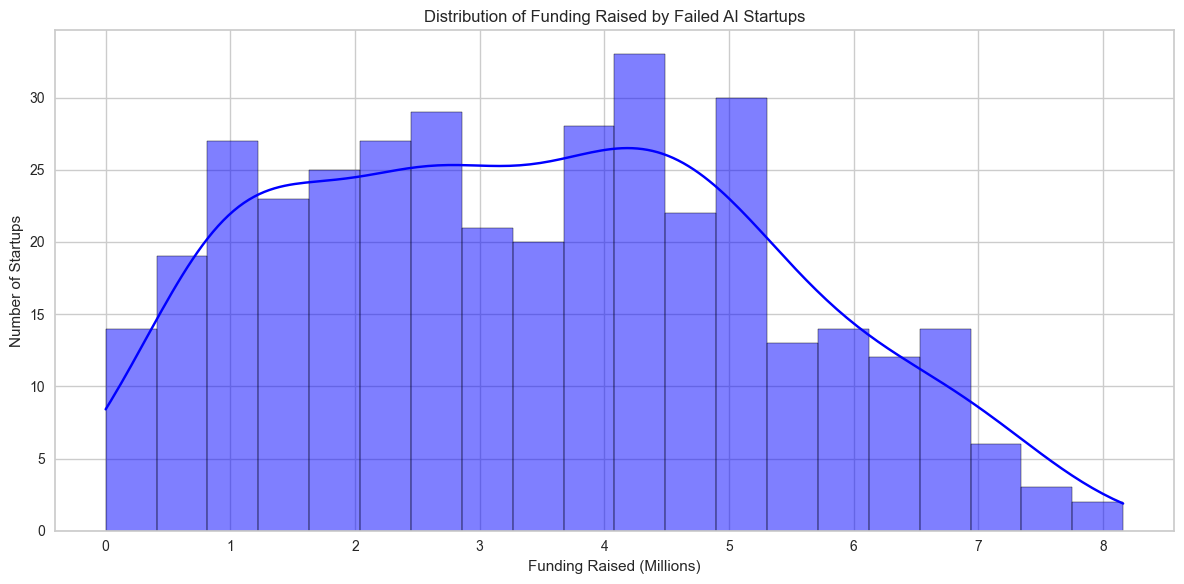

In [41]:
# Assuming 'data' is your dataframe and 'How Much They Raised (Millions)' is the funding column
plt.figure(figsize=(12, 6))
sns.histplot(data['How Much They Raised (Millions)'], kde=True, color='blue', bins=20)
plt.title("Distribution of Funding Raised by Failed AI Startups")
plt.xlabel("Funding Raised (Millions)")
plt.ylabel("Number of Startups")
plt.tight_layout()
plt.show()

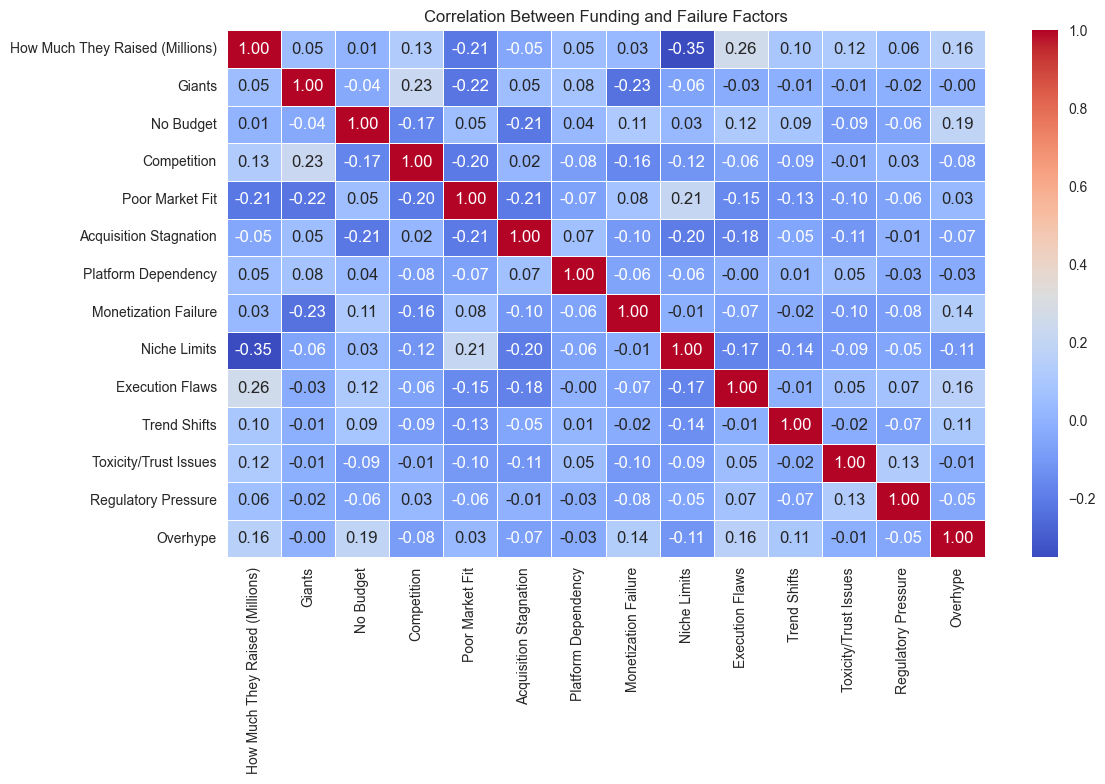

In [ ]:
# Create a correlation matrix for funding vs. failure-related features
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Create a new dataframe for funding vs. failure factors
funding_data = data_org[['How Much They Raised (Millions)'] + failure_columns]

# Calculate the correlation matrix
correlation_matrix = funding_data.corr()

# Plot a heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Funding and Failure Factors")
plt.tight_layout()
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\1365234738.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




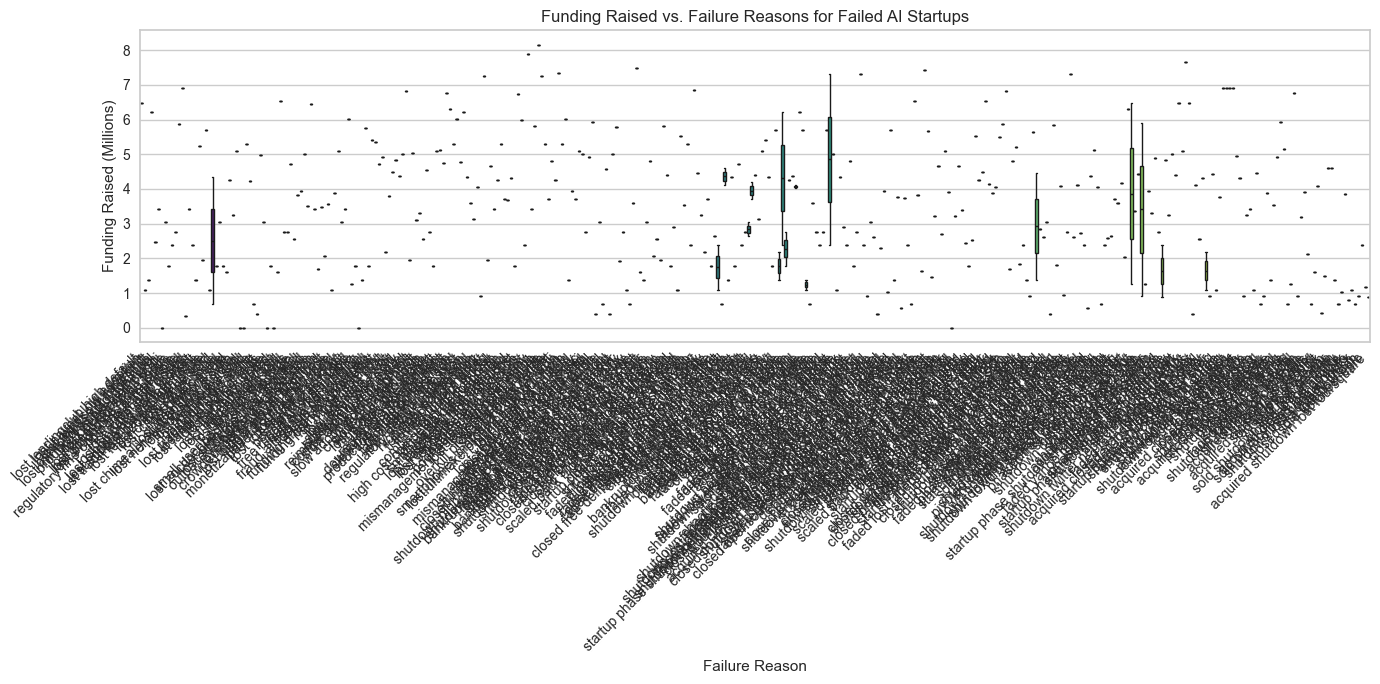

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check distribution of funding based on failure reasons
plt.figure(figsize=(14, 7))
sns.boxplot(data=data_org, x='Why They Failed', y='How Much They Raised (Millions)', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Funding Raised vs. Failure Reasons for Failed AI Startups")
plt.xlabel("Failure Reason")
plt.ylabel("Funding Raised (Millions)")
plt.tight_layout()
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\332960845.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\332960845.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\332960845.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\332960845.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

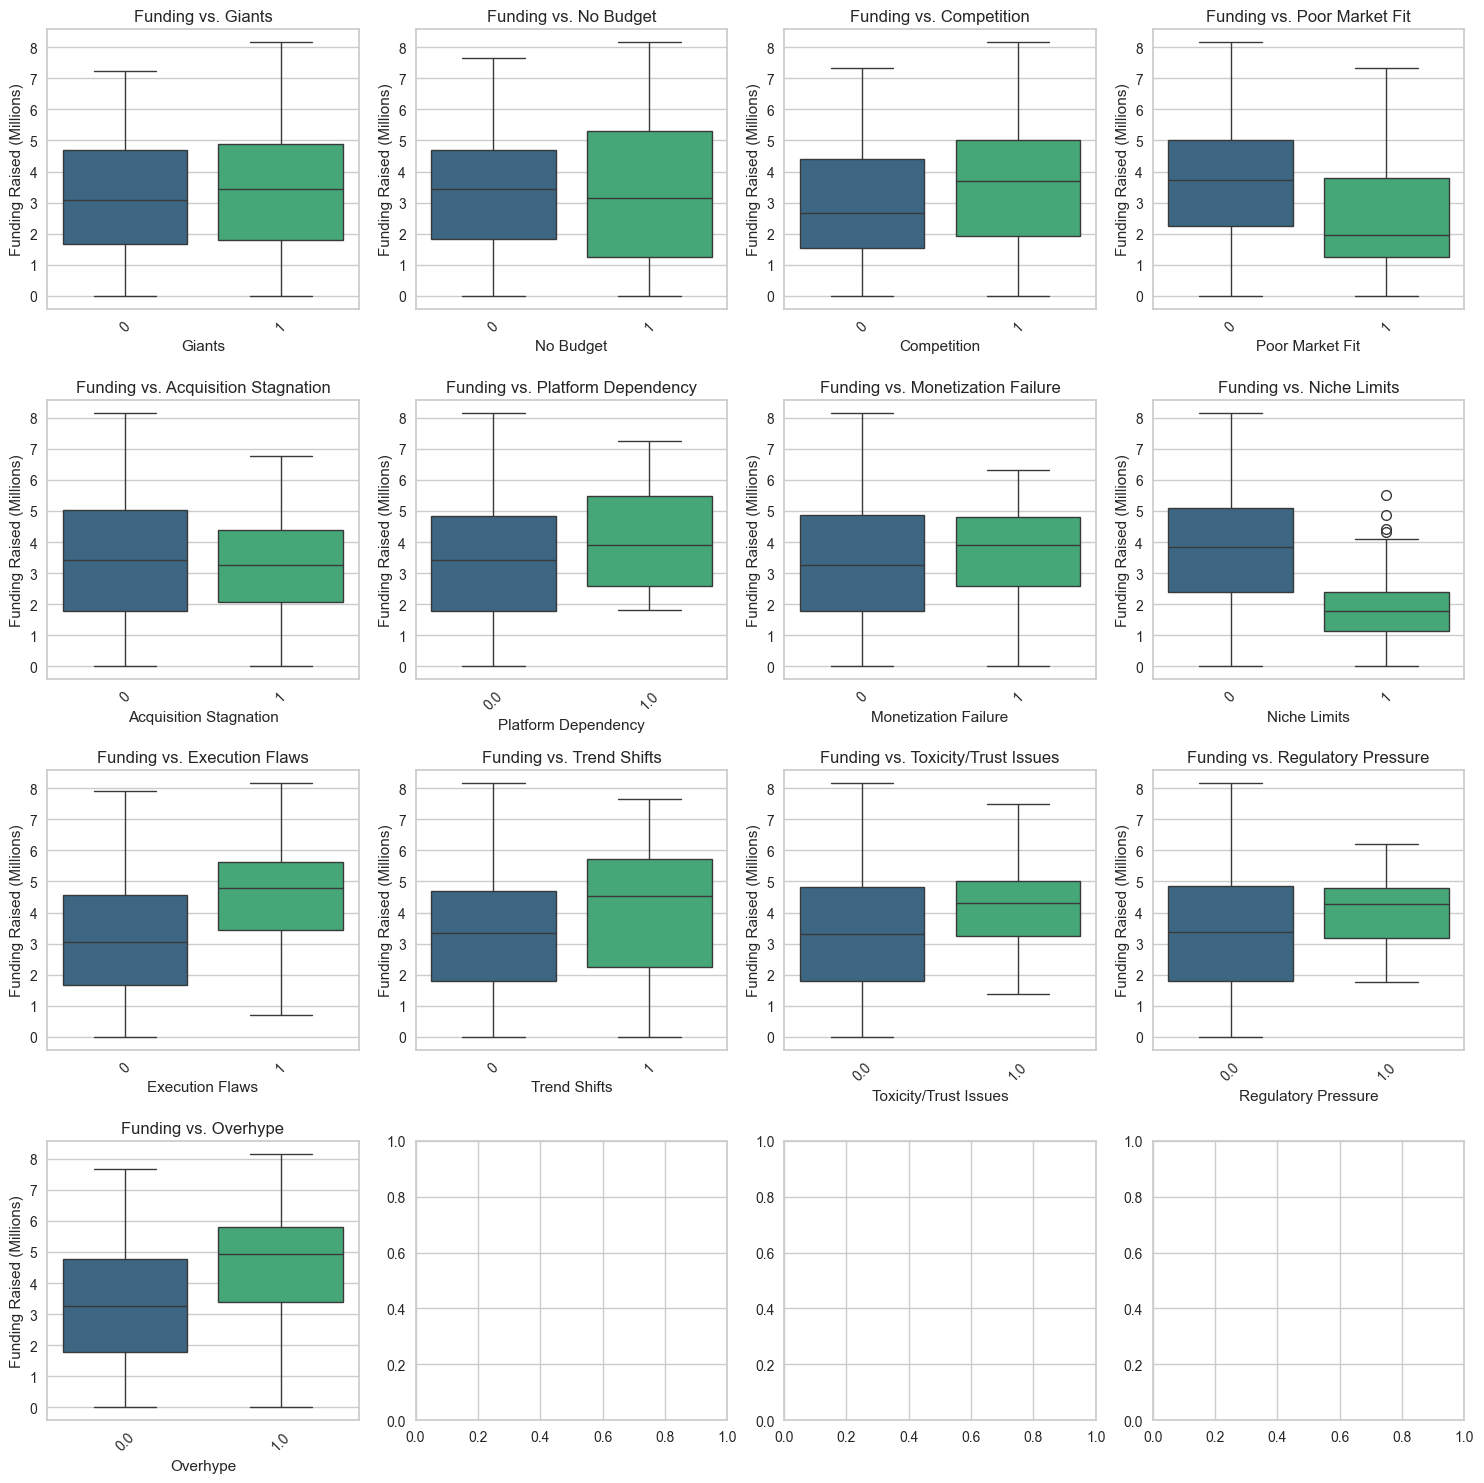

In [ ]:
# Plot the distribution of funding raised for each failure reason (using a separate plot for each)
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Create subplots for each failure reason
fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # Adjust the number of rows and columns based on the number of failure columns
axes = axes.ravel()  # Flatten the axes for easy iteration

for i, column in enumerate(failure_columns):
    sns.boxplot(data=data_org, x=column, y='How Much They Raised (Millions)', ax=axes[i], palette='viridis')
    axes[i].set_title(f"Funding vs. {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Funding Raised (Millions)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\Phong\AppData\Local\Temp\ipykernel_29972\3308298282.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




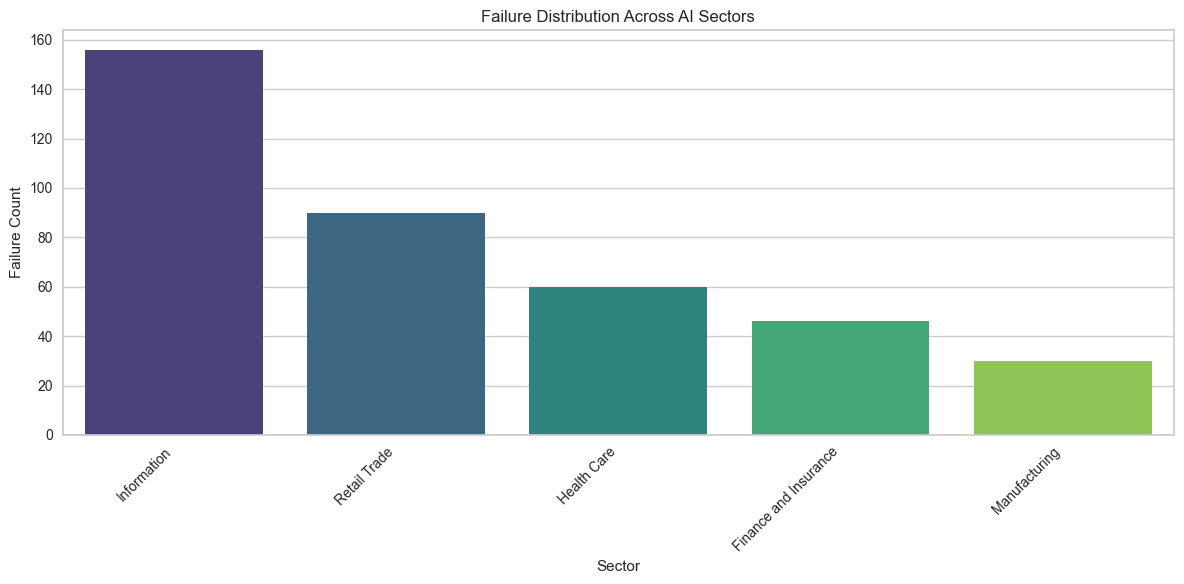

In [46]:
sector_failure_counts = data['Sector'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_failure_counts.index, y=sector_failure_counts.values, palette='viridis')
plt.title("Failure Distribution Across AI Sectors")
plt.xlabel("Sector")
plt.ylabel("Failure Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [55]:
# Checking correlation between funding and binary features (Giants, Competition)
correlation_funding_giants = data['How Much They Raised (Millions)'].corr(data['Giants'])
correlation_funding_competition = data['How Much They Raised (Millions)'].corr(data['Competition'])

print(f"Correlation between Funding and Giants: {correlation_funding_giants:.3f}")
print(f"Correlation between Funding and Competition: {correlation_funding_competition:.3f}")


Correlation between Funding and Giants: 0.047
Correlation between Funding and Competition: 0.128


Accuracy of Logistic Regression model for Competition: 0.79


d:\anaconda3\envs\dsci\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Text(0.5, 1.0, 'Logistic Regression: Funding Raised vs Competition')

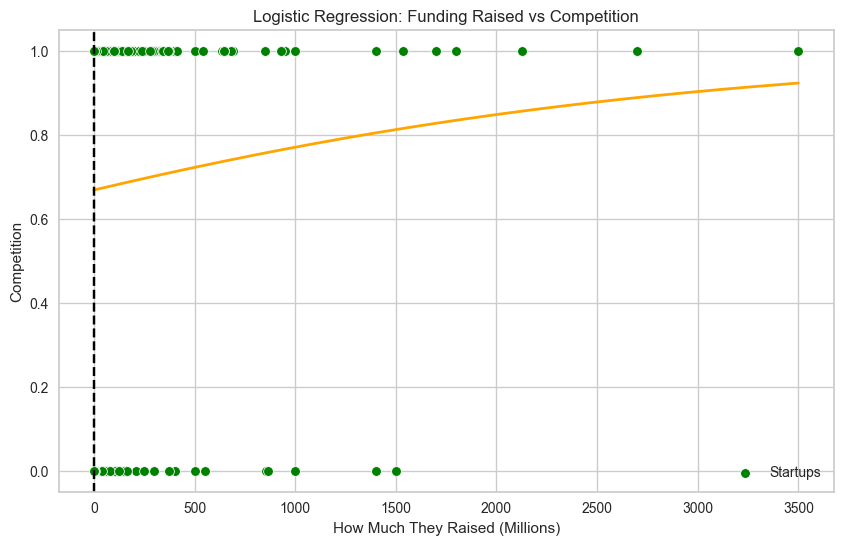

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the original dataset
X = data_org[['How Much They Raised (Millions)']]  # Feature: Funding Raised
y_competition = data_org['Competition']  # Target: Whether they faced Competition (1: Yes, 0: No)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_competition, test_size=0.2, random_state=42)

# Standardize the feature (funding raised) for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Make predictions for Competition
y_pred_competition = log_reg.predict(X_test_scaled)

# Print model accuracy for Competition
accuracy_competition = log_reg.score(X_test_scaled, y_test)
print(f"Accuracy of Logistic Regression model for Competition: {accuracy_competition:.2f}")

# Generate values for the feature (funding raised) within the range of the dataset
funding_range = np.linspace(X['How Much They Raised (Millions)'].min(), X['How Much They Raised (Millions)'].max(), 300).reshape(-1, 1)

# Standardize the values
funding_range_scaled = scaler.transform(funding_range)

# Predict the probabilities for the range of funding values (probability of facing competition)
probs_competition = log_reg.predict_proba(funding_range_scaled)[:, 1]  # Probability of facing Competition (y = 1)

# Plot the decision boundary for Competition
plt.figure(figsize=(10, 6))

# Plot the data points (scatter plot) - Funding vs Competition
sns.scatterplot(x=X['How Much They Raised (Millions)'], y=y_competition, color='green', label='Startups')

# Plot the decision boundary (probability curve)
plt.plot(funding_range, probs_competition, color='orange', label='Logistic Regression Probability', linewidth=2)

# Plotting the threshold for decision boundary (probability = 0.5)
plt.axvline(x=funding_range[np.argmax(probs_competition > 0.5)], color='black', linestyle='--', label="Decision Boundary")

# Add title and labels
plt.title("Logistic Regression: Funding Raised vs Competition")


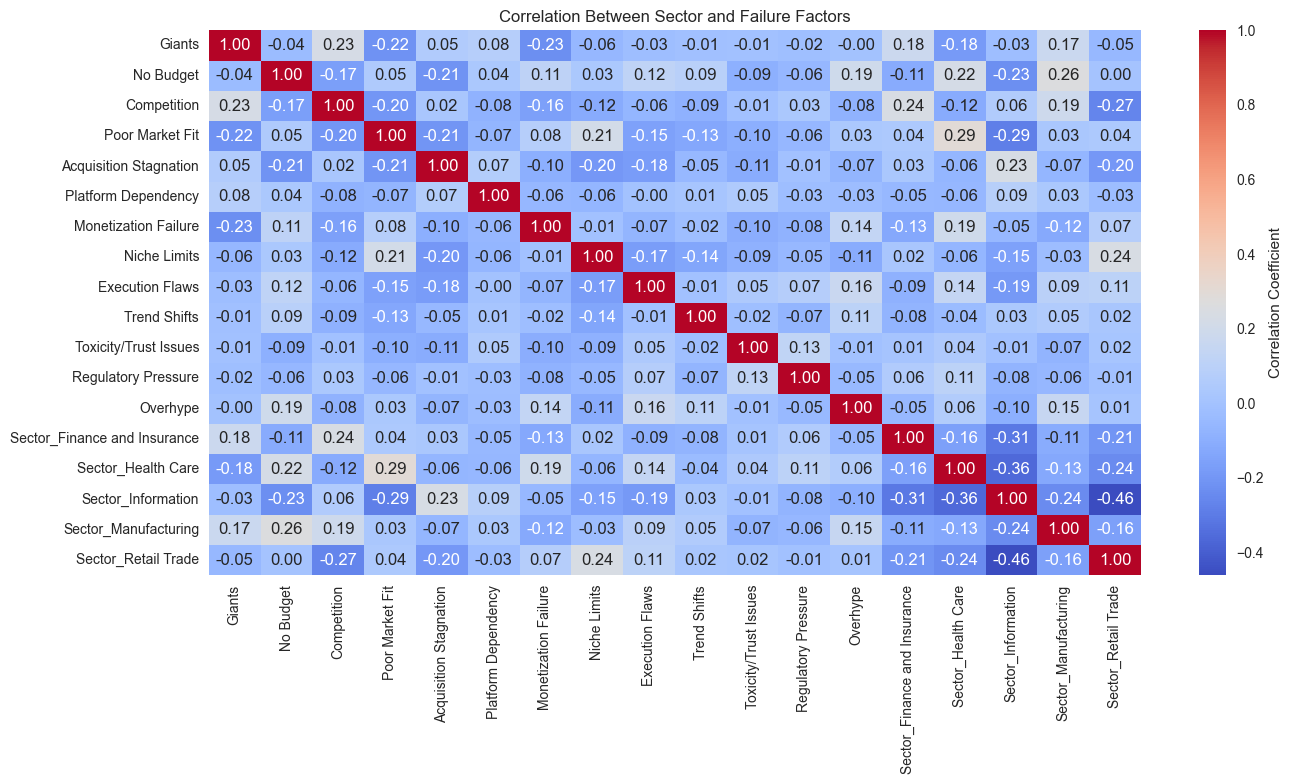

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode the 'Sector' column to create binary columns for each sector
data_encoded = pd.get_dummies(data_org, columns=['Sector'])

# List of failure-related columns from the dataset
failure_columns = [
    'Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
    'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
    'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype'
]

# Now, calculate the correlation between the one-hot encoded 'Sector' columns and failure-related factors
correlation_matrix = data_encoded[failure_columns + [col for col in data_encoded if 'Sector_' in col]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Between Sector and Failure Factors')
plt.tight_layout()
plt.show()


In [60]:
url = "https://raw.githubusercontent.com/whosphong/Ai_Startup_Failure--UAMATH509/refs/heads/main/csv/MINE2"
data_year = pd.read_csv(url)

In [62]:
# Assuming the column 'Years of Operation' contains strings like "2012-2023"

# Extract the first year from the 'Years of Operation' column
data_org['First_Year'] = data_year['Years of Operation'].str.split('-').str[0].astype(int)

In [64]:
data_org.head()

,Sector,Years of Operation,What They Did,How Much They Raised (Millions),Why They Failed,Takeaway,Giants,No Budget,Competition,Poor Market Fit,...,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype,Agglomerative_Cluster,PCA_1,PCA_2,First_Year
0,Finance and Insurance,11,Online personal loans,655.0,Lost to LendingClub and high defaults,Lending needs risk balance,1,1,1,0,...,0,0,0,0.0,0.0,0.0,1,-0.073122,0.597135,2012
1,Finance and Insurance,6,Micropayments platform,2.0,Lost to PayPal and low adoption,Micropayments need mass use,1,0,1,1,...,0,0,0,0.0,0.0,0.0,0,0.166659,-1.050131,2002
2,Finance and Insurance,5,Portfolio tracking tool,3.0,Lost to Mint and sold to TradeKing,Finance tools need scale,1,0,1,0,...,0,0,0,0.0,0.0,0.0,1,-1.715370,-0.587565,2006
3,Finance and Insurance,10,Crypto payments and stablecoin,500.0,Lost to Coinbase and market shifts,Crypto needs stability,1,0,1,0,...,0,0,1,0.0,0.0,0.0,1,-0.869280,0.822760,2013
4,Finance and Insurance,6,Personal finance app,11.0,Lost to Mint/Acorns and sold to Goldman,Finance apps need edge,1,0,1,0,...,0,0,0,0.0,0.0,0.0,1,-1.715370,-0.587565,2016


In [65]:
# Group data by founding year and calculate the sum or mean of failure factors
failure_factors_by_year = data_org.groupby('First_Year')[failure_columns].sum()

# Display the first few rows
print(failure_factors_by_year)


            Giants  No Budget  Competition  Poor Market Fit  \
First_Year                                                    
1979             0          0            1                0   
1994             2          0            0                0   
1996             2          1            0                0   
1998             4          2            2                0   
1999             1          0            1                0   
2000             1          0            1                0   
2002             6          1            5                1   
2003             3          0            3                0   
2004             3          1            2                0   
2005             3          1            3                3   
2006            15          2           12                2   
2007            13          4           12                0   
2008            18          2           19                3   
2009            25          3           22             

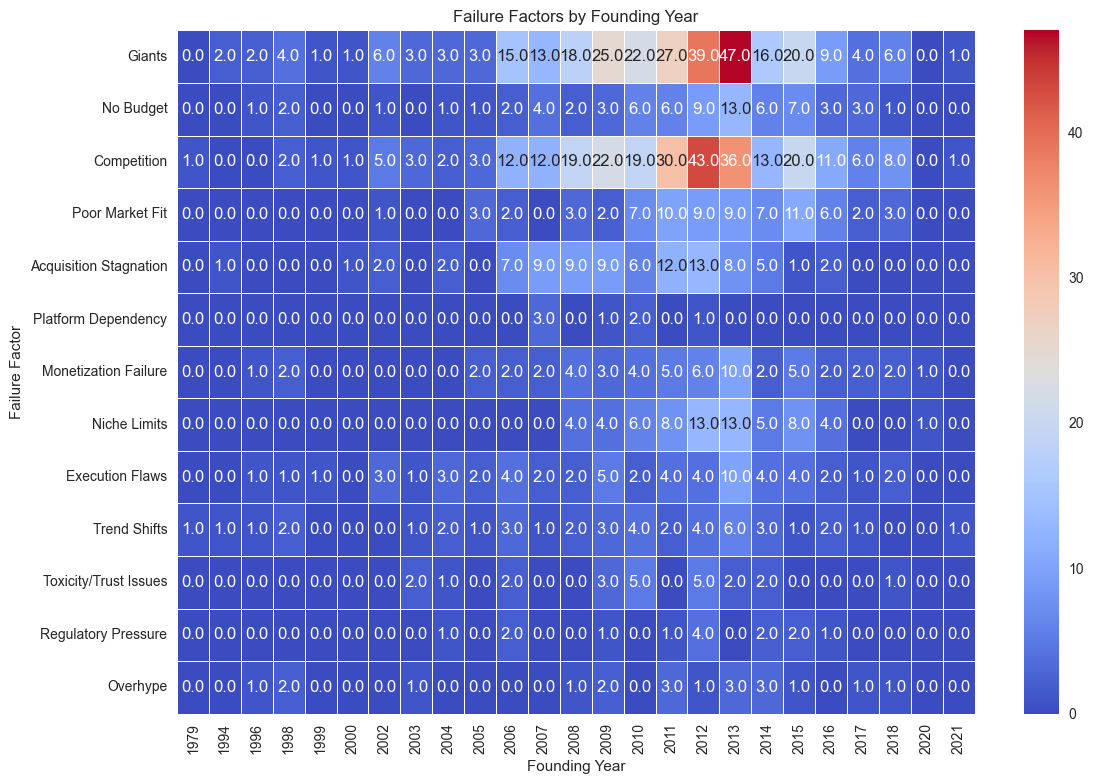

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of failure factors across different founding years
plt.figure(figsize=(12, 8))
sns.heatmap(failure_factors_by_year.T, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title('Failure Factors by Founding Year')
plt.xlabel('Founding Year')
plt.ylabel('Failure Factor')
plt.tight_layout()
plt.show()


2000-2008: Economic downturn (e.g., 2008 financial crisis). Many startups may have faced challenges in raising capital, which could have contributed to "Monetization Failure" or "No Budget".

2008-2015: The AI boom, but competition started increasing. This period could have led to failures related to "Competition" and "Execution Flaws".

2015-2020: Large-scale investments, but also increasing saturation in AI. Failures related to "Giants" or "Overhype" could have been more common.